## Create Mean Residual Error Visualization With Teams' Logo

Import necessary libraries for data manipulation (pandas), visualization (matplotlib), and working with images (OffsetImage, AnnotationBbox).

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Load three datasets:
- games_df: Contains details of NFL games.
- model_df: Includes model predictions and test scores.
- logos_path: Contains file paths for team logos to use in visualizations.

These datasets provide the foundation for merging game details with model outputs and linking team logos for enhanced visualizations.

In [2]:
filepath= "/Users/yashpatel/Desktop/nfl_games/nfl_score_prediction/data"
games_df = pd.read_csv(f"{filepath}/intermediate/games_df.csv")
model_df = pd.read_csv(f"{filepath}/output/single_random_forest_model_output.csv")
logos_path = pd.read_csv(f"{filepath}/logos_path.csv")


In [3]:
# Integrates game-specific data like team identifiers with model predictions, allowing for team-wise analysis of predictions and residuals
merged_df = pd.merge(model_df,games_df[['boxscore_stub','home_team_id','opp_team_id']], left_on=['boxscore_stub'], right_on=['boxscore_stub'], how='left')
merged_df_single = pd.merge(model_df,games_df[['boxscore_stub','home_team_id','opp_team_id']], left_on=['boxscore_stub'], right_on=['boxscore_stub'], how='left')

Calculate the mean test and predicted scores for each team across games.
The means help smooth out individual game variations, providing a clearer picture of model performance for each team over the season.
Two dataframes are created:
home_mean_merged_df: Averages for home team scores.
opp_mean_merged_df: Averages for opponent team scores.

In [4]:
# mean for each team
home_mean_merged_df = (
    merged_df.groupby('home_team_id')[['score_home_test', 'score_home_pred']]
    .mean()
    .reset_index()
).rename(columns={'home_team_id':'team_id','score_home_test':'score_test','score_home_pred':'score_pred'})

opp_mean_merged_df = (
    merged_df.groupby('opp_team_id')[['score_opp_test', 'score_opp_pred']]
    .mean()
    .reset_index()
).rename(columns={'opp_team_id':'team_id','score_opp_test':'score_test','score_opp_pred':'score_pred'})

In [5]:
# Calculating Residuals for Each Team
home_mean_merged_df['residual'] = home_mean_merged_df['score_test'] - home_mean_merged_df['score_pred']
opp_mean_merged_df['residual'] = opp_mean_merged_df['score_test'] - opp_mean_merged_df['score_pred']

In [6]:
# Update the paths for team logos to point to the correct folder location. This ensures that the logos can be properly accessed for visualizations.
folderpath = '/Users/yashpatel/Desktop/nfl_games/new_'
logos_path['path'] = logos_path['path'].apply(lambda x: f"{folderpath}{x}")

In [7]:
# Merging Data with Logos
home_vis_df = pd.merge(home_mean_merged_df,logos_path)
opp_vis_df = pd.merge(opp_mean_merged_df,logos_path)

In [8]:
# Defining Image Loading Function
def getImage(path):
    image = plt.imread(path)
    return OffsetImage(image, zoom=0.15)  # Adjust zoom for appropriate size


### Creating Visualization
Define a function to create a scatter plot of residuals with team logos positioned at their mean predicted scores.
Draw vertical lines from zero to each residual point, color-coded by team for better visualization.
This helps illustrate how the model's predictions align with the actual outcomes, highlighting over- and underestimation for each team.

In [9]:
def create_model_vis(df,game='Home'):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot for team ratings over time with invisible points
    ax.scatter(df['score_pred'], df['residual'], alpha=0)

    # Draw a horizontal line at residual = 0
    ax.axhline(0, color='black', linestyle='-', linewidth=2)

    # Add team logos at respective points and vertical lines from zero
    for _, row in df.iterrows():
        image = getImage(row['path'])
        ab = AnnotationBbox(image, (row['score_pred'], row['residual']), frameon=False)
        ax.add_artist(ab)
        
        # Get the team code for the row (assumes there is a 'team_code' column in vis_df)
        team_code = row['team_id']  # Make sure 'team_code' matches the keys in team_colors
        
        # Draw vertical lines from residual = 0 to the data point with team-specific color
        line_color = row['team_color']#team_colors.get(team_code, 'gray')  # Default to 'gray' if team code not found
        ax.vlines(x=row['score_pred'], ymin=0, ymax=row['residual'], color=line_color, linewidth=2)

    # Set labels and title
    ax.set_xlabel(f'Predicted {game} Score')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Mean Residuals Plot for {game} Team Scores (2023)')
    #ax.grid(True)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout to ensure everything fits well
    plt.tight_layout()

    # Show the plot
    return plt

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

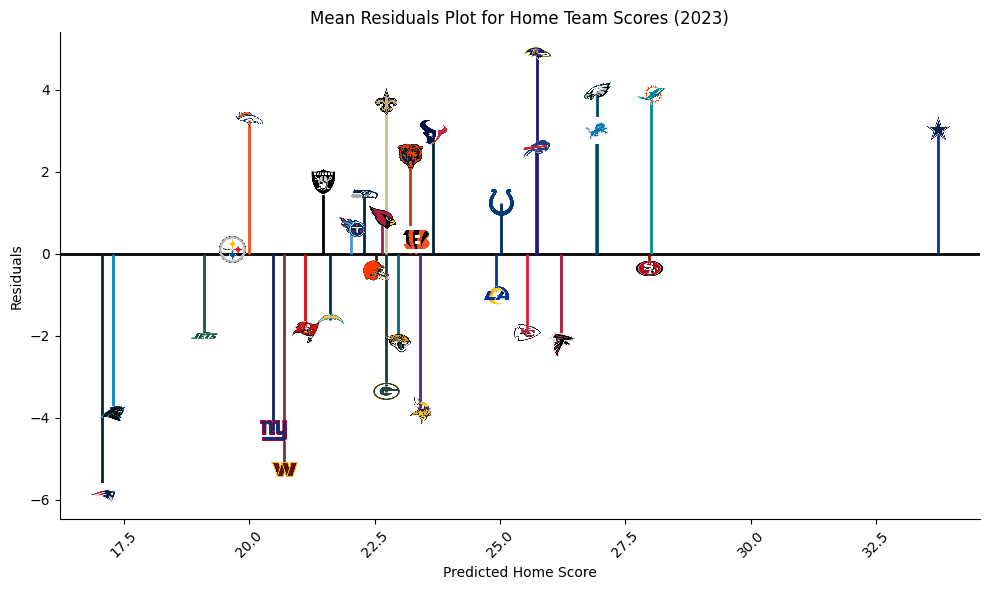

In [10]:
create_model_vis(home_vis_df,game='Home')

In [11]:
# Define an output folder and ensure it exists before saving the generated plot.
output_folder = '../data/output'
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
output_path = os.path.join(output_folder, 'rfr_2023_opp.png')

# Save the plot as a PNG file in the specified folder
create_model_vis(opp_vis_df,game='Opp').savefig(output_path, dpi=300)  # dpi=300 for high resolution